# Educational Toolkit for Plotting Vertical Profiles

## Vertical Profile info:
This is an educational toolkit to demonstrate how to plot the CESM1 data as a vertical profile.
Vertical profiles are a vertical trend chart that display a parameter measured at a specified depth, location, and time frame. In this notebook, we will be covering how to create vertical profiles plot for the historic and future projected data using `matplotlib`.

### Background information

#### Overview of Amazon Web Services (AWS)
`Amazon Web Services (AWS)` is a comprehensive and widely adopted cloud platform that offers over 200 fully-featured services from data centers globally. `AWS` provides a variety of services including computing power, storage, and databases, which can be scaled up or down depending on the user’s needs. These services help organizations lower their IT costs, improve performance, and innovate faster.

`AWS` is widely used across industries such as healthcare, finance, retail, and education due to its reliability, flexibility, and comprehensive suite of tools and services. This makes it an excellent choice for businesses looking to leverage cloud computing to enhance their operations and innovation capabilities.

##### Overview of Xarray and APIs
`Xarray` is a powerful Python library for handling multi-dimensional arrays, often used in atmospheric, oceanographic, and climate sciences. It provides a high-level API for managing labeled data, making it easy to perform complex operations on large datasets.

`APIs` (Application Programming Interfaces) allow different software applications to communicate with each other. In the context of data science, APIs provide access to various datasets and services over the internet, enabling seamless data retrieval and manipulation.

This tutorial will guide you through using Xarray and other libraries to analyze climate data from the CESM1 Large Ensemble dataset.

### CESM1 Large Ensemble
This portion of the notebook will detail how to get access to the CESM1 large Ensemble dataset, which is hosted on Amazon Web Services. Since it is hosted on Amazon Web services, the users accessing this data will not have to create a separate account. More information on the details of this dataset can be found [here](https://ncar.github.io/cesm-lens-aws/) which is also briefly discussed below. Directions will be followed very similarly to a NCAR repository labeled [CESM LENS on AWS](https://github.com/NCAR/cesm-lens-aws).

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.

Things to note about the data we are accessing:

- The notebook will be accessing the Ocean model for CESM1
- Because of this the grid file used here is only for OCEAN variables; the atmosphere and land variables have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".
- This notebook will only be looking at a few variables as an example. If you are inclined to view other variables, a whole list can be found [here](https://www.cesm.ucar.edu/community-projects/lens/data-sets)


To first open connection to where the files are housed, we need to open the connection by using the `intake` function

### Data Access
This notebook uses information from a notebook from the NCAR organization that can be found [here](https://ncar.github.io/CESM-Tutorial/notebooks/diagnostics/clm_ctsm/basics_clm.html#first-calculate-the-land-weights). To properly ensure you have the correct packages installed to correctly access the data, make sure to view the .README for this repository found [here](https://github.com/Channelislanders/toolkit).

Here we are:
- Accessing the OCN model dataset with RCP 8.5 and 20C runs. RCP 8.5 runs are the 'worst case scenario' runs, looking at years from 2000 to 2100. 20C runs are present day runs, looking at years from 1920 to 2000
- Narrowing down the columns to specific variables we aim to access. In this case, example variables can be dissolved oxygen, salinity, nutrients, and temperature (sea surface or below)

For example:
```
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)
```
In this example, we are looking for monthly data, with the component 'ocn', finding the variable 'TEMP' and locating the two experiments, 20C and RCP85.



This section works similar to accessing other catalogs. In this notebook, we will be using Zarr. More information on the library below.
https://zarr.readthedocs.io/en/stable/

### Setup and Import Packages

First, we need to import the necessary libraries for our analysis. Open a new JupyterLab notebook and execute the following code:

In [11]:
# Import necessary libraries for data analysis and visualization
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np
from rasterio import mask

# Import additional libraries needed for working with CESM1 data
import pprint
import intake
import requests
import aiohttp
import s3fs

### Load the CESM1 LENS Catalog

We start by loading the CESM1 LENS (Community Earth System Model Large Ensemble) catalog using the `intake` library:

In [12]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)  # Open the original collection description file: CESM1 LENS
col  # Display the collection


,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


## Data Exploration

### Search for Variables

Let's search for the sea surface temperature (TEMP) variable and display the first few entries in the resulting data frame:

In [13]:
# Search for the sea surface variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


Next, search for the experiments and variables we want to work with at a monthly frequency:

In [14]:
# the experiments and variables we want to work with at a monthly frequency
col.search(experiment = ["RCP85", "20C"], frequency = "monthly", variable = ["O2","SALT","TEMP","SST"]).df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,SALT,salinity,ocn,20C,monthly,60.0,global_ocean,gram/kilogram,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SAL...
2,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
3,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
4,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...
5,SALT,salinity,ocn,RCP85,monthly,60.0,global_ocean,gram/kilogram,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...
6,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...
7,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


### Detailed Search for Monthly Output

Perform a more detailed search for monthly output for the 20th century and RCP8.5 scenarios:

In [15]:
variables = ["TEMP", "SALT", "O2"]# List of cariables to search for
col_ocn = {} # Initialize an empty dictionary to store search results

# Loop through each variable to perform the search and store the results
for var in variables:
    col_ocn[f"{var}"] = col.search(
        frequency=["monthly"],
        component="ocn",
        variable=var,
        experiment=["20C", "RCP85"],
    )

print(col_ocn) # Print the search results

{'TEMP': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'SALT': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'O2': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>}


Display the first few entries in the resulting data frames:

In [16]:
col_ocn["TEMP"].df
col_ocn["SALT"].df
col_ocn["O2"].df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...


## Data Wrangling

### Load Catalog Entries into Xarray Datasets

Create a dictionary of Xarray datasets:

In [17]:
#Lets create another for loop to iteratre over the col_ocn dictionary
dsets = {} # Initialize an empty dictionary to store datasets
for var in variables:
    dsets[var] = col_ocn[var].to_dataset_dict(
        zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
    )
    print(f"\nDataset dictionary keys for {var}:\n {dsets[var].keys()}") # Print dataset dictionary keys



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for TEMP:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for SALT:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for O2:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


### Define Xarray Datasets for Each Experiment and Variable

Define Xarray datasets for the 20th century and RCP8.5 experiments:

In [18]:
# Define Xarray datasets corresponding to the two experiments by each variable 
ds_20C_TEMP = dsets["TEMP"]["ocn.20C.monthly"]  # 20th century temperature dataset
ds_RCP85_TEMP = dsets["TEMP"]["ocn.RCP85.monthly"]  # RCP8.5 temperature dataset

ds_20C_SALT = dsets["SALT"]["ocn.20C.monthly"]  # 20th century salinity dataset
ds_RCP85_SALT = dsets["SALT"]["ocn.RCP85.monthly"]  # RCP8.5 salinity dataset

ds_20C_O2 = dsets["O2"]["ocn.20C.monthly"]  # 20th century oxygen dataset
ds_RCP85_O2 = dsets["O2"]["ocn.RCP85.monthly"]  # RCP8.5 oxygen dataset


### Extract and Save a Subset of Data

For the temperature in the 20th century run, extract a subset of data and save it to a NetCDF file:

In [ ]:
#For Temperature in the 20C run
latlon_TEMP_20C = ds_20C_TEMP.isel(nlat=280, nlon=240)  # Select a specific latitude and longitude
latlon_TEMP_20C.to_netcdf("data/vertical_profile/subset_TEMP_20C.nc")  # Save the subset to a NetCDF file to a data folder (you will have to create a data folder in your working directory)

### Extract and Save a Subset of Data¶
Analyze RCP8.5 Scenario Data

Similarly, load and analyze the RCP8.5 scenario data:

In [ ]:
#For Temperature in the RCP8.5 run
latlon_TEMP_RCP85 = ds_RCP85_TEMP.isel(nlat=280, nlon=240)  # Select a specific latitude and longitude
latlon_TEMP_RCP85.to_netcdf("data/vertical_profile/subset_TEMP_RCP85.nc")  # Save the subset to a NetCDF file to a data folder (you will have to create a data folder in your working directory)

## Data Visualization

### Plotting Temperature for 20C run (1920-2005)
Load and Analyze the Subset Data

Load the NetCDF file created above and calculate the mean temperature for each member ID:

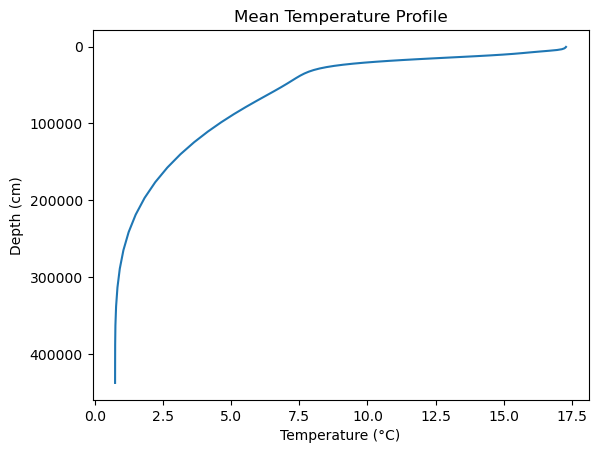

In [21]:
latlon_TEMP_final = xr.open_dataset("data/vertical_profile/subset_TEMP_20C.nc")

# Initialize an empty list to store mean temperature values for each member_id
TEMP_means_list = []

# Loop through each member_id and calculate the mean temperature over time
for member in ds_20C_TEMP.member_id:
    member_mean = latlon_TEMP_final.sel(member_id=member).TEMP.mean("time")
    TEMP_means_list.append(member_mean)

# Convert the list of means to an Xarray DataArray and calculate the overall mean
TEMP_means = xr.concat(TEMP_means_list, dim='member_id').mean('member_id')

# Plot the mean temperature profile with inverted y-axis
plt.figure()
TEMP_means.plot(y='z_t')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (cm)')
plt.title('Mean Temperature Profile')
plt.show()


### Plotting Tempertaure for RCP8.5 run (2006-2100)
Load and Analyze the Subset Data

Load the NetCDF file created above and calculate the mean temperature for each member ID:

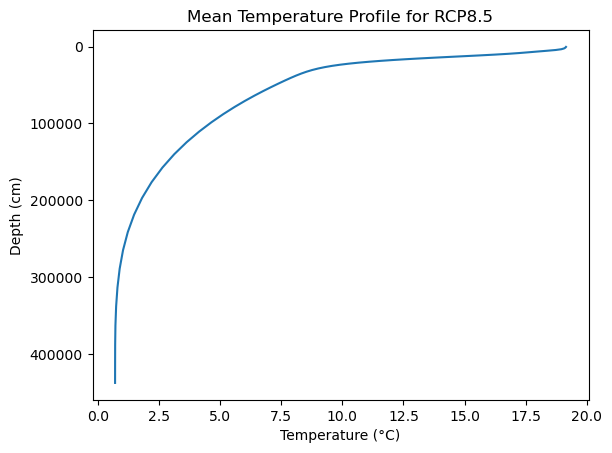

In [11]:
latlon_TEMP_final_rcp = xr.open_dataset("subset_TEMP_RCP85.nc")

# Initialize an empty list to store mean temperature values for each member_id
TEMP_means_list_rcp = []

# Loop through each member_id and calculate the mean temperature over time
for member in latlon_TEMP_final_rcp.member_id:
    member_mean_rcp = latlon_TEMP_final_rcp.sel(member_id=member).TEMP.mean("time")
    TEMP_means_list_rcp.append(member_mean_rcp)

# Convert the list of means to an Xarray DataArray and calculate the overall mean
TEMP_means_rcp = xr.concat(TEMP_means_list_rcp, dim='member_id').mean('member_id')

# Plot the mean temperature profile for RCP8.5 scenario
plt.figure()
TEMP_means_rcp.plot(y='z_t')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (cm)')
plt.title('Mean Temperature Profile for RCP8.5')
plt.show()



This tutorial provides a step-by-step guide to working with CESM1 LENS data using Xarray and related libraries. You can extend this analysis to include other variables or different subsets of the data as needed.